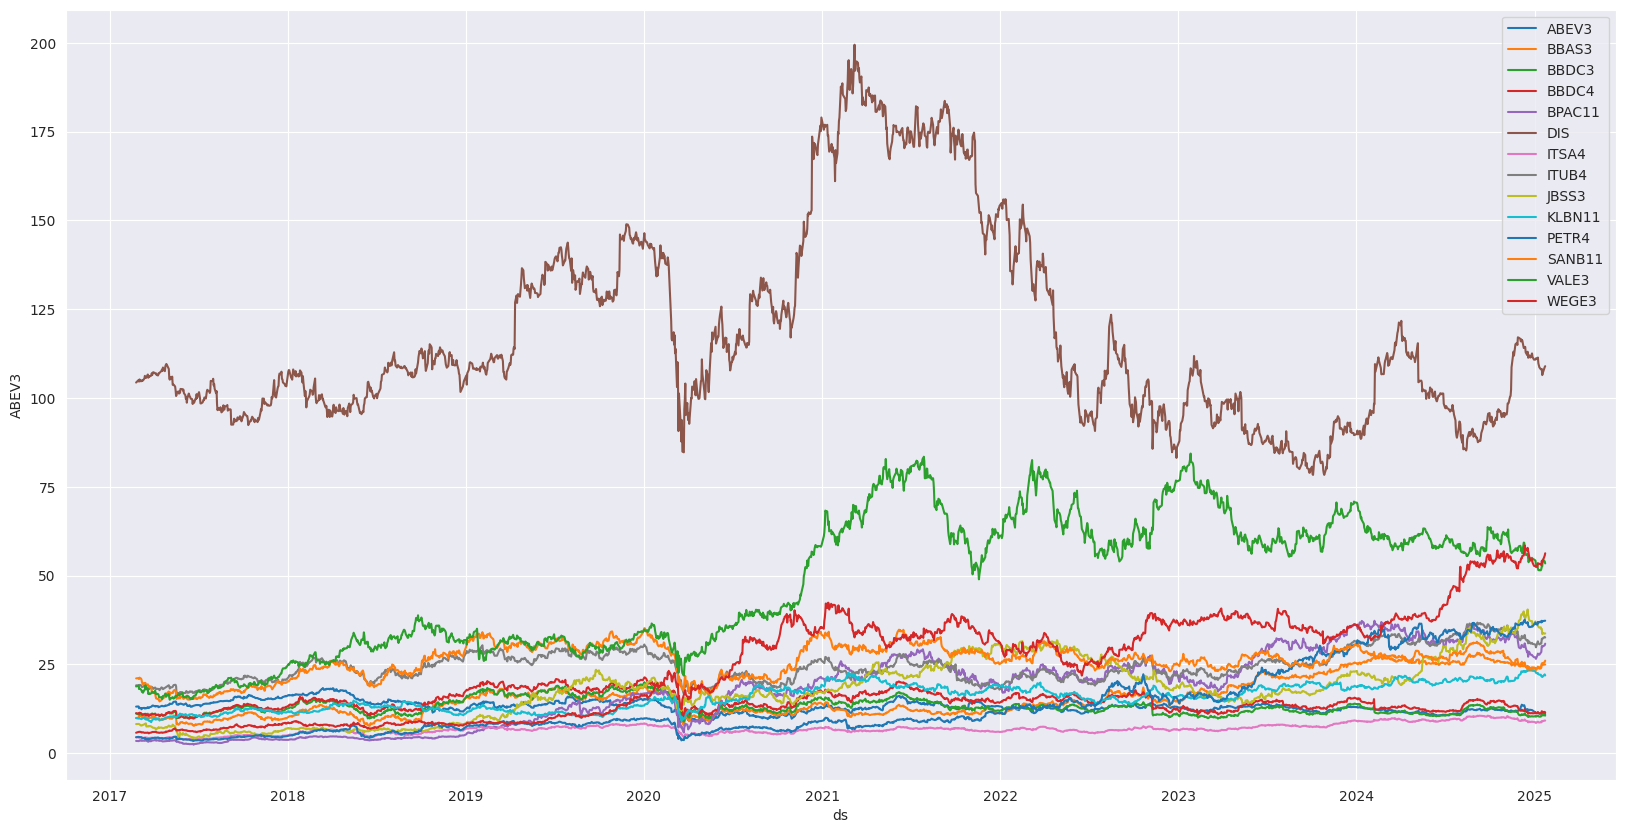

In [13]:
# Bibliotecas
import deltalake
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Carregando os dados
df = deltalake.DeltaTable(table_uri="data/raw/yfinance_api").to_pandas()
df.value_counts(subset=["unique_id"])

# Pegando apenas as datas onde todos possuem valor
df_v1 = df.copy()
date_filter = df_v1.groupby("ds")["unique_id"].count() == 14
dates_to_consider = []
for date, to_consider in date_filter.items():
    if to_consider:
        dates_to_consider.append(date)
df_v1 = df_v1[df_v1["ds"].isin(dates_to_consider)].reset_index(drop=True)

# Transformando cada ação em uma coluna com os valores 'y' e o índice será a data
df_v2 = pd.pivot_table(
    data=df_v1,
    values="y",
    columns="unique_id",
    index="ds"
).sort_index()

# Visualizando
sns.set_style("darkgrid")
plt.figure(figsize=(20, 10))

for col in df_v2.columns:
    sns.lineplot(
        data=df_v2,
        x=df_v2.index,
        y=col,
        label=col
    )

plt.show()

In [16]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Normalizando os dados usando o MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(X=df_v2.values)

# Criando as sequências (in e target)
num_features_in = df_v2.shape[1]
num_features_out = num_features_in
input_sequence_length = 30
output_sequence_length = 14
total_sequence_lenght = input_sequence_length + output_sequence_length

x = []
y = []

for i in range(data.shape[0] - total_sequence_lenght):
    x.append(data[i:i + input_sequence_length])
    y.append(data[i + input_sequence_length : i + total_sequence_lenght])

x = np.array(x)
y = np.array(y)

# Dividindo em dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Transformando em tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Criando os datasets (TensorDatasets)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Criando os  DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [215]:
import torch
from torch import nn


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_features, output_sequence_length):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_features)
        self.output_sequence_length = output_sequence_length

    def forward(self, x):
        # LSTM output shape: (batch_size, input_sequence_length, hidden_size)
        out, _ = self.lstm(x)
        # Slice the last `output_sequence_length` steps and apply FC
        out = self.fc(out[:, -self.output_sequence_length:, :])
        return out  # Shape: (batch_size, 7, 14)


hidden_size = 32  # Can be tuned based on your problem

model = LSTMModel(
    input_size=num_features_in,
    hidden_size=hidden_size,
    num_features=num_features_out,
    output_sequence_length=output_sequence_length
)

# Loss function and optimizer
criterion = nn.MSELoss()
lr = 0.000_1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
num_epochs = 100
loss_history = []
for epoch in range(num_epochs):  # Number of epochs
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)  # Shape: (batch_size, 7, 14)
        loss = criterion(outputs, y_batch)  # Compare to target
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")
        loss_history.append(loss.item())

model.eval()
with torch.no_grad():
    total_loss = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)  # Shape: (batch_size, 7, 14)
        loss = criterion(outputs, y_batch)
        total_loss += loss.item()

    print(f"Test Loss: {total_loss / len(test_loader):.4f}")


Epoch 10, Loss: 0.0324
Epoch 20, Loss: 0.0102
Epoch 30, Loss: 0.0056
Epoch 40, Loss: 0.0054
Epoch 50, Loss: 0.0028
Epoch 60, Loss: 0.0030
Epoch 70, Loss: 0.0017
Epoch 80, Loss: 0.0020
Epoch 90, Loss: 0.0016
Epoch 100, Loss: 0.0011
Test Loss: 0.0014


In [222]:
X_batch[0].shape

torch.Size([7, 14])

In [228]:
model(torch.tensor(np.linspace(start=0, stop=10, num=14), dtype=torch.float32).reshape(1, 1, 14))

tensor([[[-0.2416,  0.2534,  0.5040,  0.2087,  0.4814,  0.1754,  1.1427,
           0.7477,  0.5269,  0.5584,  0.3024,  0.5543,  0.7361,  0.8972]]],
       grad_fn=<ViewBackward0>)

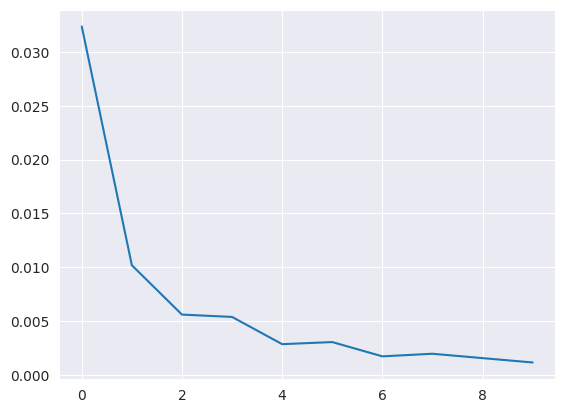

In [216]:
plt.plot(list(range(len(loss_history))), loss_history)
plt.show()

In [224]:
from src.utils import get_path_project

DIR_PROJECT = get_path_project()
MODEL_PATH = DIR_PROJECT / "ml_models/my_lstm.pth"

torch.save(obj=model.state_dict(), f=MODEL_PATH)

In [1]:
import torch
import yaml
from src.custom_neural_networks import LSTMModel
from src.utils import get_path_project

DIR_PROJECT = get_path_project()
CONFIG_PATH = DIR_PROJECT / "config/custom_lstm_config.yaml"

# Load the config file
with open(CONFIG_PATH, "r") as yaml_file:
    config = yaml.safe_load(yaml_file)

# Extract model hyperparameters
model_params = config["model"]
training_params = config["training"]

# Initialize the model

model = LSTMModel(**model_params)
print(model)

MODEL_PATH = DIR_PROJECT / "ml_models/my_lstm.pth"

model.load_state_dict(torch.load(f=MODEL_PATH, weights_only=True))

LSTMModel(
  (lstm): LSTM(14, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=14, bias=True)
)


<All keys matched successfully>

In [3]:
import numpy as np

model.eval()
model(torch.tensor(np.linspace(start=0, stop=10, num=14), dtype=torch.float32).reshape(1, 1, 14))

tensor([[[-0.2416,  0.2534,  0.5040,  0.2087,  0.4814,  0.1754,  1.1427,
           0.7477,  0.5269,  0.5584,  0.3024,  0.5543,  0.7361,  0.8972]]],
       grad_fn=<ViewBackward0>)

# VERSÃO DEFINITIVA

In [1]:
# Bibliotecas
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import deltalake
import pandas as pd

# Carregando os dados
df = deltalake.DeltaTable(table_uri="data/raw/yfinance_api").to_pandas()
df.value_counts(subset=["unique_id"])

# Pegando apenas as datas onde todos possuem valor
df_v1 = df.copy()
date_filter = df_v1.groupby("ds")["unique_id"].count() == 14
dates_to_consider = []
for date, to_consider in date_filter.items():
    if to_consider:
        dates_to_consider.append(date)
df_v1 = df_v1[df_v1["ds"].isin(dates_to_consider)].reset_index(drop=True)

# Transformando cada ação em uma coluna com os valores 'y' e o índice será a data
df_v2 = pd.pivot_table(
    data=df_v1,
    values="y",
    columns="unique_id",
    index="ds"
).sort_index()

# Normalizando os dados usando o MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(X=df_v2.values)

# Criando as sequências (in e target)
num_features_in = df_v2.shape[1] # É o número de ações!!!
num_features_out = num_features_in # Queremos prever uma sequência temporal das ações, então é a mesma dimensão da entrada
input_sequence_length = 30 # Vamos treinar com ums série de 30 dias ...
output_sequence_length = 7 # ... para prever quais serão os próximos 7 dias
total_sequence_lenght = input_sequence_length + output_sequence_length # Então faremos um recorte de tamanho 37 (in+out)

x = []
y = []

for i in range(data.shape[0] - total_sequence_lenght):
    x.append(data[i:i + input_sequence_length])
    y.append(data[i + input_sequence_length : i + total_sequence_lenght])

x = np.array(x)
y = np.array(y)

# Dividindo em dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Transformando em tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Criando os datasets (TensorDatasets)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Criando os  DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
import torch
from torch import nn


class LSTMModel(nn.Module):
    def __init__(
            self, 
            num_stocks:int, 
            num_lstm_layers:int, 
            lstm_out_size:int, 
            output_sequence_length:int
        ) -> None:
        super().__init__()

        # Camada LSTM
        self.lstm = nn.LSTM(
            input_size=num_stocks, 
            num_layers=num_lstm_layers, 
            hidden_size=lstm_out_size, 
            batch_first=True
        )

        # Camada Linear
        self.fc = nn.Linear(
            in_features=lstm_out_size, 
            out_features=num_stocks
        )

        # Tamanho da série temporal na saída
        self.output_sequence_length = output_sequence_length

        return None

    def forward(self, x):
        # Passando a entrada pela LSTM
        out, _ = self.lstm(x) # LSTM output shape: (batch_size, input_sequence_length, hidden_size)

        # Pegando apenas os valores q `output_sequence_length` e jogando na camada linear
        out = self.fc(out[:, -self.output_sequence_length:, :]) # Shape: (batch_size, output_sequence_length, num_stocks)

        return out  


class ModelTrainer():
    def __init__(self, model, learning_rate:float=0.001, num_epochs:int=500) -> None:
        self.model = model
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.num_epochs = num_epochs
        self.loss_history = []
        return None

    def train(self, train_loader) -> None:
        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)

                # 
                loss = self.loss_fn(outputs, y_batch)
                loss.backward()

                #
                self.optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")
                self.loss_history.append(loss.item())
        return None

    def test(self, test_loader) -> None:
        self.model.eval()
        with torch.no_grad():
            total_loss = 0
            for X_batch, y_batch in test_loader:
                outputs = self.model(X_batch)  # Shape: (batch_size, 7, 14)
                loss = self.loss_fn(outputs, y_batch)
                total_loss += loss.item()

            print(f"Test Loss: {total_loss / len(test_loader):.4f}")
        return None
            

# num_stocks = 14 # Número de ações (14)
# num_lstm_layers = 3 # Quantas camadas empilhadas de LSTM queremos
# lstm_out_size = 32 # É o hidden_size
# output_sequence_length = 7 # Valor a ser predito no futuro

# model = LSTMModel(
#     num_stocks=num_stocks,
#     num_lstm_layers=num_lstm_layers,
#     lstm_out_size=lstm_out_size,
#     output_sequence_length=output_sequence_length
# )

# # Loss function and optimizer
# num_epochs = 50
# model_trainer = ModelTrainer(model = model, learning_rate= 0.01, num_epochs=num_epochs)
# model_trainer.train(train_loader=train_loader)
# model_trainer.test(test_loader=test_loader)

In [ ]:
from src.utils import get_path_project

DIR_PROJECT = get_path_project()
MODEL_PATH = DIR_PROJECT / "ml_models/my_lstm.pth"

torch.save(obj=model.state_dict(), f=MODEL_PATH)

In [17]:
model_params

{'num_stocks': 14,
 'num_lstm_layers': 32,
 'lstm_out_size': 14,
 'output_sequence_length': 7}

In [4]:
import torch
import yaml
# from src.custom_neural_networks import LSTMModel
from src.utils import get_path_project

DIR_PROJECT = get_path_project()
CONFIG_PATH = DIR_PROJECT / "config/custom_lstm_config.yaml"

# Load the config file
with open(CONFIG_PATH, "r") as yaml_file:
    config = yaml.safe_load(yaml_file)

# Extract model hyperparameters
model_params = config["model"]
training_params = config["training"]

# Initialize the model
model = LSTMModel(**model_params)
model_trainer = ModelTrainer(model=model, **training_params)
print(model._parameters)
model_trainer.train(train_loader=train_loader)

# MODEL_PATH = DIR_PROJECT / "ml_models/my_lstm.pth"

# model.load_state_dict(torch.load(f=MODEL_PATH, weights_only=True))

{}
Epoch 10, Loss: 0.0626
Epoch 20, Loss: 0.0643
Epoch 30, Loss: 0.0576
Epoch 40, Loss: 0.0601
Epoch 50, Loss: 0.0493


In [27]:
model_trainer.model.ge

{}

In [29]:
for a in model.parameters():
    print(a)

Parameter containing:
tensor([[-0.1392, -0.2195, -0.0345,  0.0685,  0.1129, -0.2613, -0.1919,  0.0997,
         -0.0760, -0.2542, -0.0866,  0.2159, -0.1973, -0.2195],
        [-0.2227, -0.2143,  0.0446, -0.0042,  0.0116, -0.2039,  0.1789,  0.0732,
          0.0581,  0.1787,  0.2504, -0.1536, -0.1378, -0.0500],
        [-0.0825, -0.1628, -0.1362, -0.0547, -0.1385, -0.0533, -0.0614,  0.1754,
         -0.1490,  0.2603,  0.0306, -0.2406, -0.1807, -0.2584],
        [-0.2390,  0.2423, -0.0818, -0.1080,  0.1243, -0.0179, -0.1958, -0.2562,
         -0.2313, -0.0178, -0.2640,  0.0298,  0.0802,  0.2547],
        [-0.1965, -0.1326, -0.2440, -0.0375,  0.1367,  0.2111, -0.0567, -0.0892,
          0.0244, -0.1062, -0.2328, -0.1042, -0.1158,  0.1848],
        [ 0.0564, -0.1705, -0.1705,  0.0730,  0.0909, -0.0074, -0.1079,  0.0869,
          0.2473,  0.2019, -0.2644, -0.1374, -0.0276, -0.2021],
        [-0.0155,  0.0997, -0.0518,  0.1572, -0.1206, -0.1397,  0.0380, -0.0813,
         -0.0296,  0.0505, 

In [10]:
import torch
from torch import nn
from pprint import pprint

A = torch.rand(2, 3, 9) # batch_size, in_sequence_len, num_ações

lstm = nn.LSTM(input_size=9,num_layers=1,hidden_size=18,batch_first=True)
lstm_out, _ = lstm(A)
pprint(lstm_out.shape)

linear = nn.Linear(in_features=18,out_features=9)
linear_out = linear(lstm_out[:, -2:, :])
pprint(linear_out.shape)

torch.Size([2, 3, 18])
torch.Size([2, 2, 9])
